In [ ]:

pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:

pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [1]:
from spacy.cli import download

download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [151]:
import pandas as pd
import numpy as np
import regex as re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
news_df = pd.read_excel("data/news_excerpts_parsed.xlsx")
wiki_df = pd.read_excel("data/wikileaks_parsed.xlsx")

pd.set_option('display.max_colwidth', None)

In [5]:
print(news_df.head())

                                                                                                                           Link  \
0                                                  https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
1         https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731   
2                                         https://edition.cnn.com/2023/05/22/tech/meta-facebook-data-privacy-eu-fine/index.html   
3  https://www.channelnewsasia.com/singapore/billion-dollar-money-laundering-case-zhang-ruijin-sentenced-15-months-jail-4302416   
4                                 https://edition.cnn.com/2024/03/05/politics/liberty-university-fined-campus-safety/index.html   

                                                                                                                                                                                                                     

In [6]:
print(wiki_df.head())

  PDF Path  \
0    1.pdf   
1    1.pdf   
2   10.pdf   
3   10.pdf   
4   10.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [7]:

news_df['text_cleaned'] = news_df['Text'].str.lower()
wiki_df['text_cleaned'] = wiki_df['Text'].str.lower()

print(news_df.head())

                                                                                                                           Link  \
0                                                  https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
1         https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731   
2                                         https://edition.cnn.com/2023/05/22/tech/meta-facebook-data-privacy-eu-fine/index.html   
3  https://www.channelnewsasia.com/singapore/billion-dollar-money-laundering-case-zhang-ruijin-sentenced-15-months-jail-4302416   
4                                 https://edition.cnn.com/2024/03/05/politics/liberty-university-fined-campus-safety/index.html   

                                                                                                                                                                                                                     

In [8]:
nlp = spacy.load('en_core_web_sm') # Load spaCy model

In [9]:
# Process the text using a spaCy pipeline to tokenize,
news_df['doc'] = news_df['text_cleaned'].apply(nlp)
news_df['entities'] = news_df['doc'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])
news_df['tokens'] = news_df['doc'].apply(lambda doc: [token.text for token in doc])

In [10]:
wiki_df['doc'] = wiki_df['text_cleaned'].apply(nlp)
wiki_df['entities'] = wiki_df['doc'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])
wiki_df['tokens'] = wiki_df['doc'].apply(lambda doc: [token.text for token in doc])

In [11]:
def extract_token_details(doc):
    token_data = []
    for token in doc:
        token_data.append({
            "text": token.text,
            "lemma": token.lemma_,
            "pos": token.pos_,
            "tag": token.tag_,
            "dep": token.dep_,
            "shape": token.shape_,
            "is_alpha": token.is_alpha,
            "is_stop": token.is_stop
        })
    return token_data

In [12]:
news_df['token_details'] = news_df['doc'].apply(extract_token_details)

In [13]:
wiki_df['token_details'] = wiki_df['doc'].apply(extract_token_details)

In [14]:

news_token_df = news_df.explode('token_details')
news_token_df = pd.concat(
    [news_token_df.drop(columns=['token_details']), news_token_df['token_details'].apply(pd.Series)],
    axis=1
)

wiki_token_df = wiki_df.explode('token_details')
wiki_token_df = pd.concat(
    [wiki_token_df.drop(columns=['token_details']), wiki_token_df['token_details'].apply(pd.Series)],
    axis=1
)

# Display the token-level DataFrame
print(news_token_df)
print(wiki_token_df)

                                                                                                                      Link  \
0                                             https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
0                                             https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
0                                             https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
0                                             https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
0                                             https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html   
...                                                                                                                    ...   
1508  https://www.straitstimes.com/singapore/parliament-new-measures-to-guard-against-money-laundering-terrorist-finan

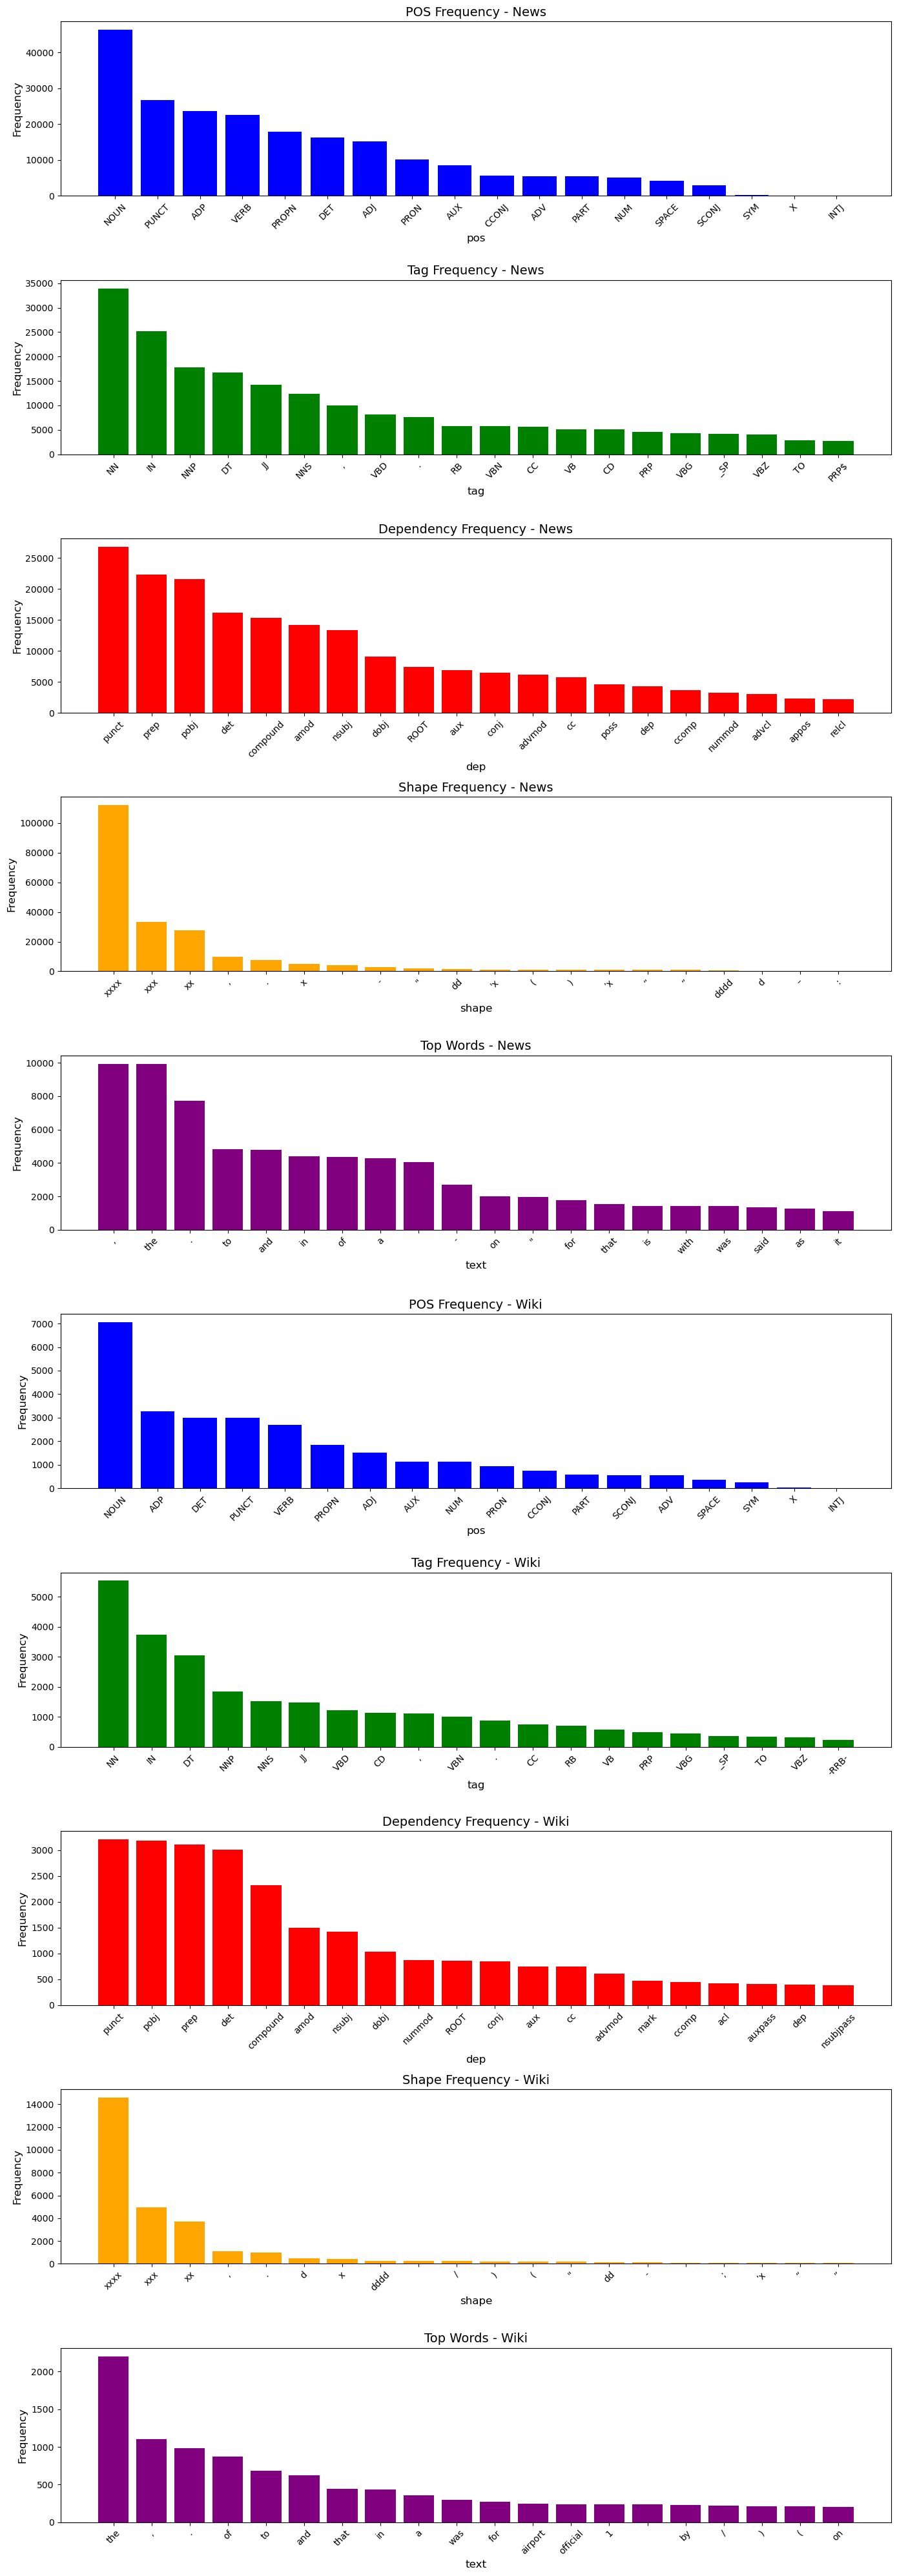

In [15]:
# Function to plot frequency distributions for a given column
def plot_column_frequency(df, column_name, ax, color, title, top_n=20):
    value_counts = df[column_name].value_counts().head(top_n)  # Get top N most frequent
    ax.bar(value_counts.index, value_counts.values, color=color)
    ax.set_title(title, fontsize=14)  # Larger title
    ax.set_xlabel(column_name, fontsize=12)  # Larger label
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='x', labelsize=10, rotation=45)  # Rotate labels for better visibility

# Define number of rows (one per plot)
n_rows = 10
fig, axs = plt.subplots(n_rows, 1, figsize=(14, 40))  # One graph per row

# Plot for news_token_df
plot_column_frequency(news_token_df, 'pos', axs[0], 'blue', 'POS Frequency - News')
plot_column_frequency(news_token_df, 'tag', axs[1], 'green', 'Tag Frequency - News')
plot_column_frequency(news_token_df, 'dep', axs[2], 'red', 'Dependency Frequency - News')
plot_column_frequency(news_token_df, 'shape', axs[3], 'orange', 'Shape Frequency - News')
plot_column_frequency(news_token_df, 'text', axs[4], 'purple', 'Top Words - News')

# Plot for wiki_token_df
plot_column_frequency(wiki_token_df, 'pos', axs[5], 'blue', 'POS Frequency - Wiki')
plot_column_frequency(wiki_token_df, 'tag', axs[6], 'green', 'Tag Frequency - Wiki')
plot_column_frequency(wiki_token_df, 'dep', axs[7], 'red', 'Dependency Frequency - Wiki')
plot_column_frequency(wiki_token_df, 'shape', axs[8], 'orange', 'Shape Frequency - Wiki')
plot_column_frequency(wiki_token_df, 'text', axs[9], 'purple', 'Top Words - Wiki')

# Adjust layout
plt.tight_layout()
plt.show()


In [16]:
# For news_df
news_is_alpha_pos = news_token_df.groupby(['is_alpha', 'pos']).size().unstack(fill_value=0)
print(news_is_alpha_pos)

# For wiki_df
wiki_is_alpha_pos = wiki_token_df.groupby(['is_alpha', 'pos']).size().unstack(fill_value=0)
print(wiki_is_alpha_pos)


pos         ADJ    ADP   ADV   AUX  CCONJ    DET  INTJ   NOUN   NUM  PART  \
is_alpha                                                                    
False       282      5     6   213     35      1     1    364  3335  2036   
True      14845  23613  5511  8234   5615  16252    57  45907  1770  3401   

pos        PRON  PROPN  PUNCT  SCONJ  SPACE  SYM   VERB   X  
is_alpha                                                     
False         7    638  26667      1   4162  276    217  52  
True      10197  17275      7   2845      0    1  22361  51  
pos        ADJ   ADP  ADV   AUX  CCONJ   DET  INTJ  NOUN   NUM  PART  PRON  \
is_alpha                                                                     
False       31     0    0     0      7     0     0    76  1004    96    23   
True      1497  3275  551  1141    736  3009    13  6980   120   475   914   

pos       PROPN  PUNCT  SCONJ  SPACE  SYM  VERB   X  
is_alpha                                             
False       192   2988

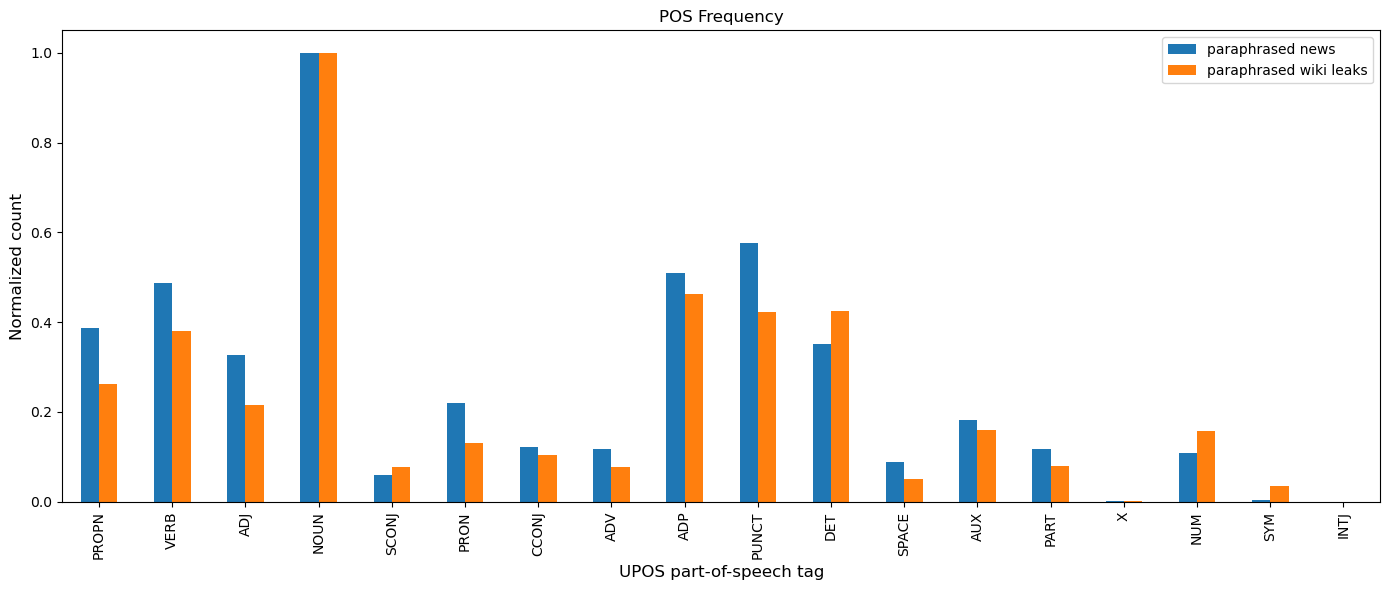

In [146]:
# Min-Max Normalization
news_pos_counts = Counter(news_token_df['pos'])
news_pos_counts = pd.DataFrame.from_dict(news_pos_counts, orient='index').reset_index()

wiki_pos_counts = Counter(wiki_token_df['pos'])
wiki_pos_counts = pd.DataFrame.from_dict(wiki_pos_counts, orient='index').reset_index()

pos_counts_df = pd.merge(news_pos_counts, wiki_pos_counts, on='index', how='outer', suffixes=('news', 'wiki'))
pos_counts_df.rename(columns={'0news': 'paraphrased news', '0wiki':'paraphrased wiki leaks'}, inplace=True)

pos_counts_df = pos_counts_df.drop(columns=['index'])
pos_counts_df = (pos_counts_df-pos_counts_df.min())/(pos_counts_df.max()-pos_counts_df.min())
pos_counts_df = pd.concat([pos_counts_df, news_pos_counts['index']], axis=1)

# Create subplots to compare the POS tag frequencies
pos_counts_df = pd.DataFrame(pos_counts_df)
pos_counts_df.set_index('index', inplace=True)
ax = pos_counts_df.plot(kind='bar', stacked=False, figsize=(14, 6))

ax.set_xlabel("UPOS part-of-speech tag", fontsize=12) 
ax.set_ylabel("Normalized count", fontsize=12) 
ax.set_title('POS Frequency')
plt.tight_layout()
plt.show()

In [169]:
a_pos = np.array(pos_counts_df['paraphrased news'])
b_pos = np.array(pos_counts_df['paraphrased wiki leaks'])

# Function to check for zero vectors
def cosine_similarity_safe(a, b):
    # Check if any of the vectors is a zero vector
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0  # You can return 0 or handle as needed, since they are orthogonal in this case.
    
    # If not zero, calculate cosine similarity
    return 1 - cosine(a, b)

# Calculate cosine similarity
cosine_similarity_pos = cosine_similarity_safe(a_pos, b_pos)
print(f"Cosine Similarity: {round(cosine_similarity_pos,4)}")

Cosine Similarity: 0.9843


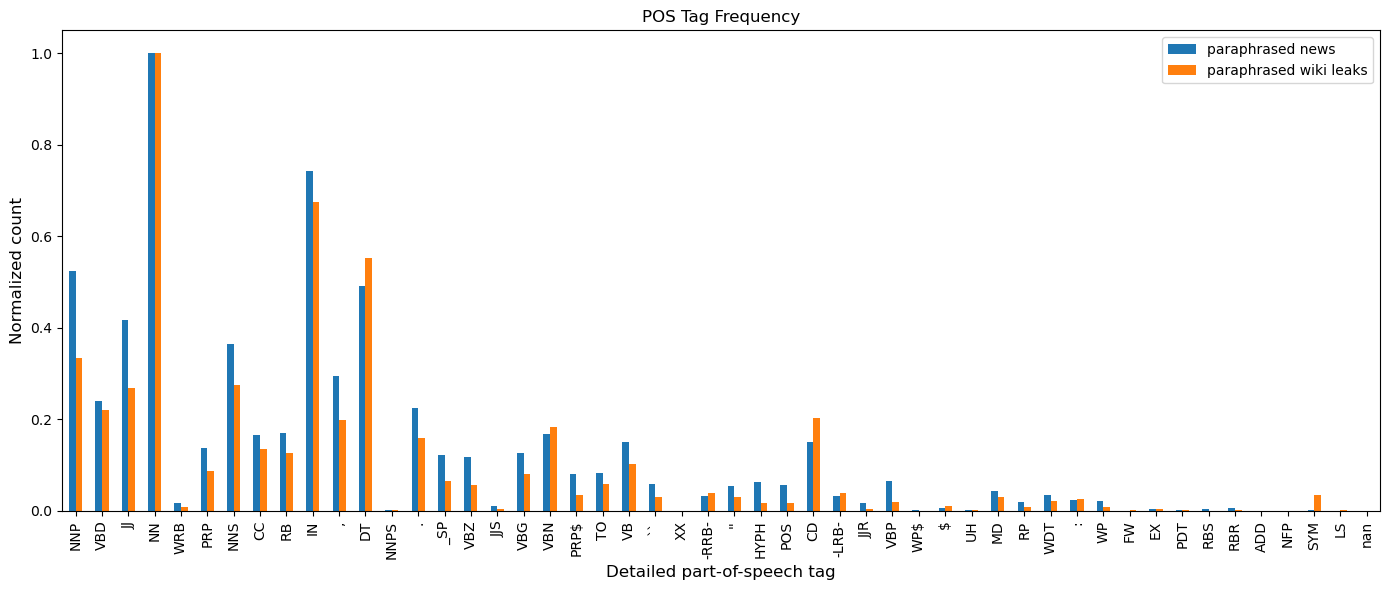

In [149]:
# Min-Max Normalization
news_tag_counts = Counter(news_token_df['tag'])
news_tag_counts = pd.DataFrame.from_dict(news_tag_counts, orient='index').reset_index()

wiki_tag_counts = Counter(wiki_token_df['tag'])
wiki_tag_counts = pd.DataFrame.from_dict(wiki_tag_counts, orient='index').reset_index()

tag_counts_df = pd.merge(news_tag_counts, wiki_pos_counts, on='index', how='outer', suffixes=('news', 'wiki'))
tag_counts_df.rename(columns={'0news': 'paraphrased news', '0wiki':'paraphrased wiki leaks'}, inplace=True)

tag_counts_df = tag_counts_df.drop(columns=['index'])
tag_counts_df = (tag_counts_df-tag_counts_df.min())/(tag_counts_df.max()-tag_counts_df.min())
tag_counts_df = pd.concat([tag_counts_df, news_tag_counts['index']], axis=1)

# Create subplots to compare the POS tag frequencies
tag_counts_df = pd.DataFrame(tag_counts_df)
tag_counts_df.set_index('index', inplace=True)
ax = tag_counts_df.plot(kind='bar', stacked=False, figsize=(14, 6))

ax.set_xlabel("Detailed part-of-speech tag", fontsize=12) 
ax.set_ylabel("Normalized count", fontsize=12) 
ax.set_title('POS Tag Frequency')
plt.tight_layout()
plt.show()

In [157]:
a_tag = np.array(tag_counts_df['paraphrased news'])
b_tag = np.array(tag_counts_df['paraphrased wiki leaks'])

# Calculate cosine similarity
cosine_similarity_tag = cosine_similarity_safe(a_tag, b_tag)
print(f"Cosine Similarity: {round(cosine_similarity_tag,2)}")

Cosine Similarity: 1


In [ ]:
pip uninstall gensim

In [ ]:
conda install -c anaconda gensim

In [ ]:
from gensim import corpora, models, similarities
from gensim.matutils import softcossim

# Load the documents
doc1 = "This is a sample document."
doc2 = "Here is another document to compare."

# Create a dictionary from the documents
dictionary = corpora.Dictionary([doc1.split(), doc2.split()])

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc.split()) for doc in [doc1, doc2]]

print(corpus)

# # Train a TF-IDF model on the corpus
# tfidf = models.TfidfModel(corpus)

# # Create a similarity matrix using the soft cosine similarity function
# similarity_matrix = similarities.SoftCosineSimilarity(
#     tfidf[corpus], similarity_matrix=None, num_features=len(dictionary))

# # Compute the soft cosine similarity between the two documents
# soft_similarity = softcossim(tfidf[dictionary.doc2bow(doc1.split())],
#                               tfidf[dictionary.doc2bow(doc2.split())],
#                               similarity_matrix)

# print("Soft cosine similarity between the two documents: ", soft_similarity)

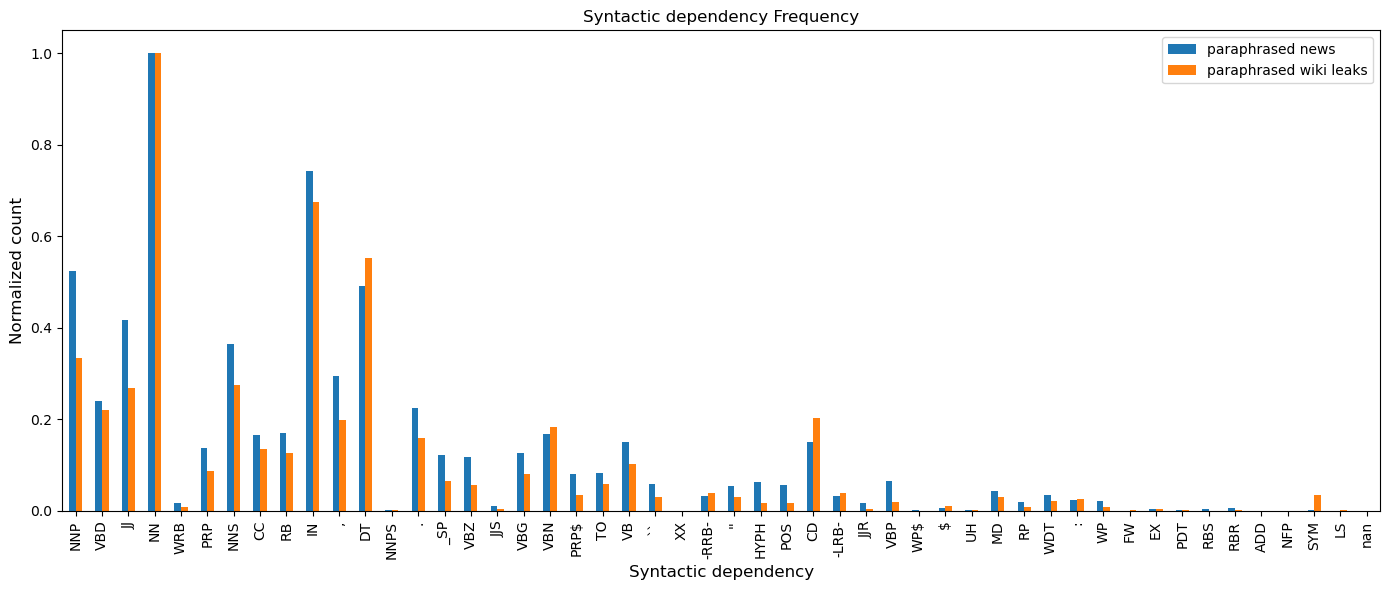

In [158]:
# Min-Max Normalization
news_dep_counts = Counter(news_token_df['tag'])
news_dep_counts = pd.DataFrame.from_dict(news_dep_counts, orient='index').reset_index()

wiki_dep_counts = Counter(wiki_token_df['tag'])
wiki_dep_counts = pd.DataFrame.from_dict(wiki_dep_counts, orient='index').reset_index()

dep_counts_df = pd.merge(news_dep_counts, wiki_dep_counts, on='index', how='outer', suffixes=('news', 'wiki'))
dep_counts_df.rename(columns={'0news': 'paraphrased news', '0wiki':'paraphrased wiki leaks'}, inplace=True)

dep_counts_df = dep_counts_df.drop(columns=['index'])
dep_counts_df = (dep_counts_df-dep_counts_df.min())/(dep_counts_df.max()-dep_counts_df.min())
dep_counts_df = pd.concat([dep_counts_df, news_dep_counts['index']], axis=1)

# Create subplots to compare the dep tag frequencies
dep_counts_df = pd.DataFrame(dep_counts_df)
dep_counts_df.set_index('index', inplace=True)
ax = dep_counts_df.plot(kind='bar', stacked=False, figsize=(14, 6))

ax.set_xlabel("Syntactic dependency", fontsize=12) 
ax.set_ylabel("Normalized count", fontsize=12) 
ax.set_title('Syntactic dependency Frequency')
plt.tight_layout()
plt.show()

In [166]:
a_dep = np.array(dep_counts_df['paraphrased news'])
b_dep = np.array(dep_counts_df['paraphrased wiki leaks'])

# Calculate cosine similarity
cosine_similarity_dep = cosine_similarity_safe(a_dep, b_dep)
print(f"Cosine Similarity: {round(cosine_similarity_dep,4)}")

Cosine Similarity: 1


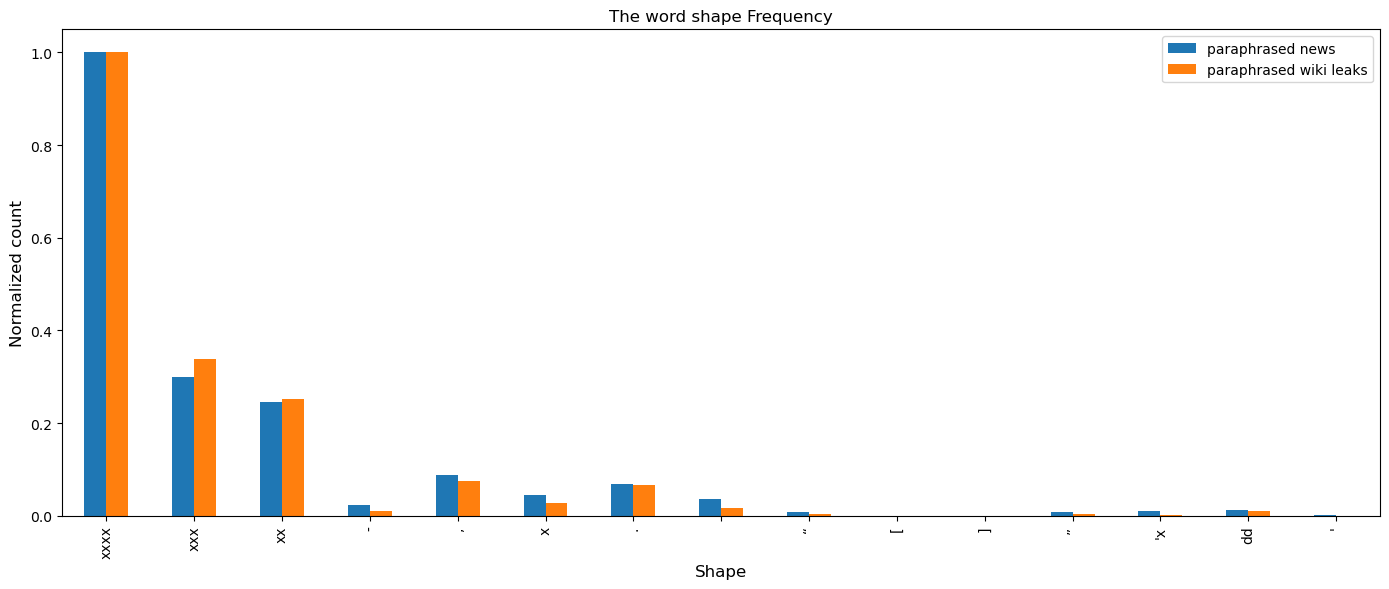

In [160]:
# Min-Max Normalization
news_shape_counts = Counter(news_token_df['shape'])
news_shape_counts = pd.DataFrame.from_dict(news_shape_counts, orient='index').reset_index()

wiki_shape_counts = Counter(wiki_token_df['shape'])
wiki_shape_counts = pd.DataFrame.from_dict(wiki_shape_counts, orient='index').reset_index()

shape_counts_df = pd.merge(news_shape_counts, wiki_shape_counts, on='index', how='outer', suffixes=('news', 'wiki'))
shape_counts_df.rename(columns={'0news': 'paraphrased news', '0wiki':'paraphrased wiki leaks'}, inplace=True)

shape_counts_df = shape_counts_df.drop(columns=['index'])
shape_counts_df = (shape_counts_df-shape_counts_df.min())/(shape_counts_df.max()-shape_counts_df.min())
shape_counts_df = pd.concat([shape_counts_df, news_shape_counts['index']], axis=1)

# Create subplots to compare the shape tag frequencies
shape_counts_df = pd.DataFrame(shape_counts_df.head(15))
shape_counts_df.set_index('index', inplace=True)
ax = shape_counts_df.plot(kind='bar', stacked=False, figsize=(14, 6))

ax.set_xlabel("Shape", fontsize=12) 
ax.set_ylabel("Normalized count", fontsize=12) 
ax.set_title('The word shape Frequency')
plt.tight_layout()
plt.show()

In [164]:
a_shape = np.array(shape_counts_df['paraphrased news'])
b_shape = np.array(shape_counts_df['paraphrased wiki leaks'])

# Calculate cosine similarity
cosine_similarity_shape = cosine_similarity_safe(a_shape, b_shape)
print(f"Cosine Similarity: {round(cosine_similarity_shape,4)}")

Cosine Similarity: 0.9988


In [133]:
top_10_words_in_news = (news_token_df['text'].value_counts()).iloc[:10]
top_10_words_in_wiki = (wiki_token_df['text'].value_counts()).iloc[:10]
print("Top 10 text in paraphrased news\n",top_10_words_in_news)
print("Top 10 text in paraphrased wiki leaks\n",top_10_words_in_wiki)

Top 10 text in paraphrased news
 ,       9946
the     9926
.       7737
to      4846
and     4779
in      4409
of      4377
a       4304
\n\n    4051
-       2684
Name: text, dtype: int64
Top 10 text in paraphrased wiki leaks
 the     2204
,       1104
.        982
of       872
to       679
and      623
that     441
in       432
a        355
was      295
Name: text, dtype: int64
Top 10 text in paraphrased news
 ,       9946
the     9926
.       7737
be      5100
to      4847
and     4779
in      4410
of      4377
a       4304
\n\n    4051
Name: lemma, dtype: int64
Top 10 text in paraphrased wiki leaks
 the     2204
,       1104
.        982
of       872
be       736
to       679
and      623
that     441
in       432
a        355
Name: lemma, dtype: int64
